# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.utils import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [267]:
# # # Here is a helping code that will download and unzip the dataset for you.
# # # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [268]:
df = pd.read_csv("/content/Traffic Data.csv", parse_dates=['date_time'], index_col=['date_time'])
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [270]:
df['weather_main'].unique()

array(['Mist', 'Clear', 'Clouds', 'Rain', 'Thunderstorm', 'Fog',
       'Drizzle', 'Snow', 'Haze', 'Smoke'], dtype=object)

In [271]:
df['weather_description'].unique()

array(['mist', 'sky is clear', 'broken clouds', 'moderate rain',
       'proximity shower rain', 'proximity thunderstorm', 'fog',
       'light rain', 'overcast clouds', 'light intensity drizzle',
       'scattered clouds', 'proximity thunderstorm with rain',
       'light snow', 'haze', 'few clouds', 'heavy intensity rain', 'snow',
       'drizzle', 'heavy intensity drizzle', 'thunderstorm',
       'Sky is Clear', 'heavy snow', 'thunderstorm with heavy rain',
       'light shower snow', 'shower drizzle',
       'thunderstorm with light rain', 'thunderstorm with rain',
       'thunderstorm with light drizzle',
       'proximity thunderstorm with drizzle', 'smoke',
       'light intensity shower rain', 'sleet', 'light rain and snow',
       'freezing rain'], dtype=object)

In [272]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [273]:
df.sort_index(inplace=True)

In [274]:
df.index

DatetimeIndex(['2016-11-18 15:00:00', '2016-11-18 15:00:00',
               '2016-11-18 15:00:00', '2016-11-18 16:00:00',
               '2016-11-18 16:00:00', '2016-11-18 16:00:00',
               '2016-11-18 17:00:00', '2016-11-18 17:00:00',
               '2016-11-18 17:00:00', '2016-11-18 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=20000, freq=None)

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [275]:
# get rid of null values by using fill forward to easily plot
df = df.ffill()

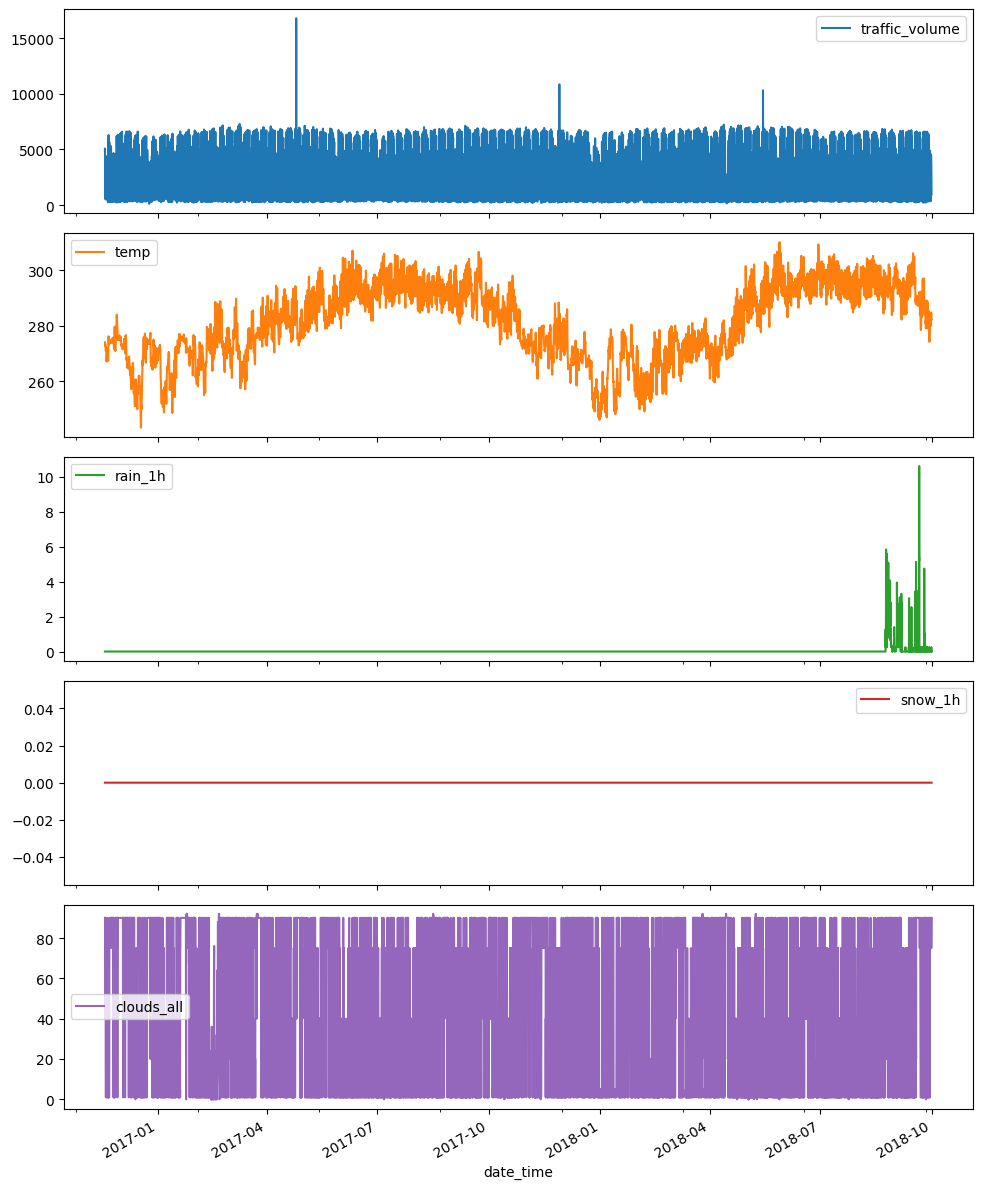

In [276]:
df.plot(subplots=True, figsize=(10, 12))
plt.tight_layout()
plt.legend()
plt.show()

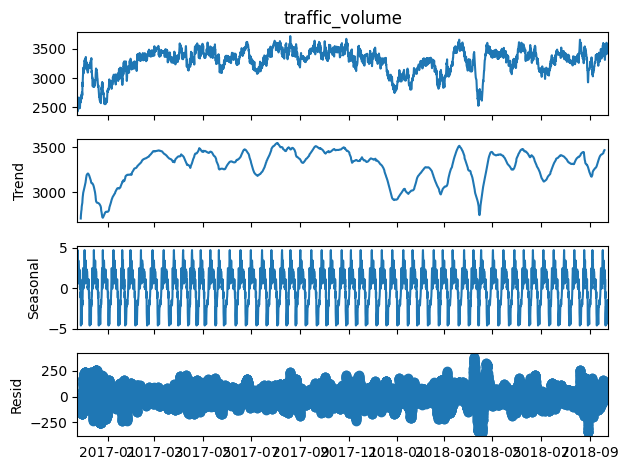

In [277]:
 moving_avg = df['traffic_volume'].rolling(window=365, center=True).mean()

 moving_avg = moving_avg.dropna()
decomposition = seasonal_decompose(moving_avg, model='additive', period=365)
decomposition.plot()
plt.show()

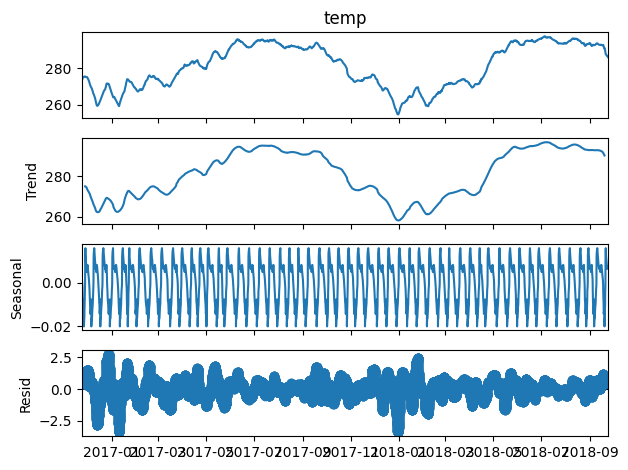

In [278]:
 moving_avg = df['temp'].rolling(window=365, center=True).mean()

 moving_avg = moving_avg.dropna()
decomposition = seasonal_decompose(moving_avg, model='additive', period=365)
decomposition.plot()
plt.show()

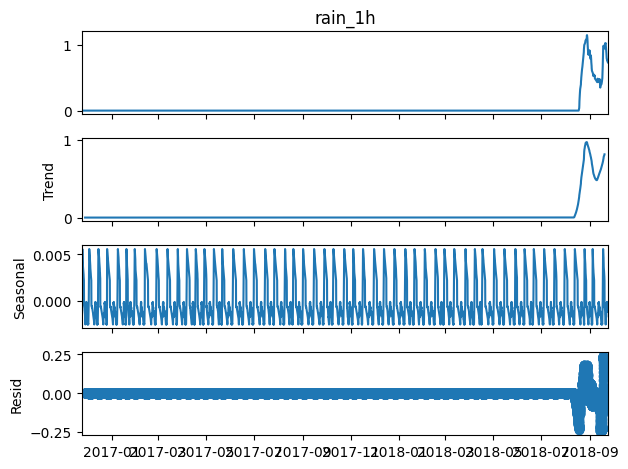

In [279]:
 moving_avg = df['rain_1h'].rolling(window=365, center=True).mean()

 moving_avg = moving_avg.dropna()
decomposition = seasonal_decompose(moving_avg, model='additive', period=365)
decomposition.plot()
plt.show()

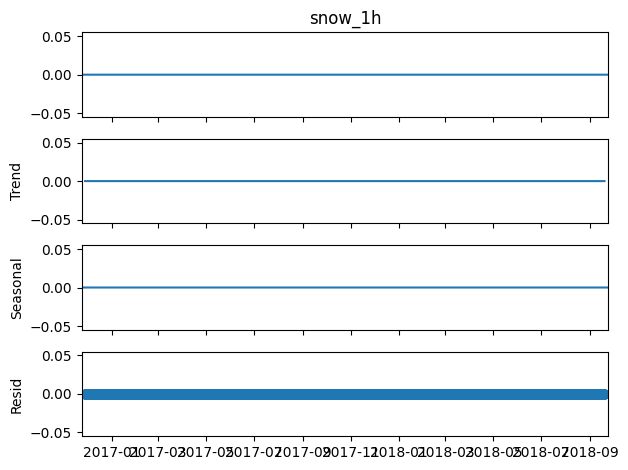

In [280]:
 moving_avg = df['snow_1h'].rolling(window=365, center=True).mean()

 moving_avg = moving_avg.dropna()
decomposition = seasonal_decompose(moving_avg, model='additive', period=365)
decomposition.plot()
plt.show()

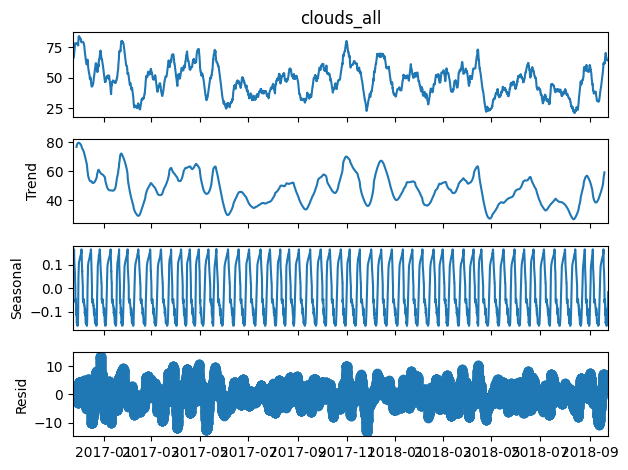

In [281]:
 moving_avg = df['clouds_all'].rolling(window=365, center=True).mean()

 moving_avg = moving_avg.dropna()
decomposition = seasonal_decompose(moving_avg, model='additive', period=365)
decomposition.plot()
plt.show()

In [282]:
df[df['rain_1h'] > 0].count()

,0
traffic_volume,713
temp,713
rain_1h,713
snow_1h,713
clouds_all,713
weather_main,713
weather_description,713


In [283]:
df[df['snow_1h'] > 0].count()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


**Boxplot**

<Axes: >

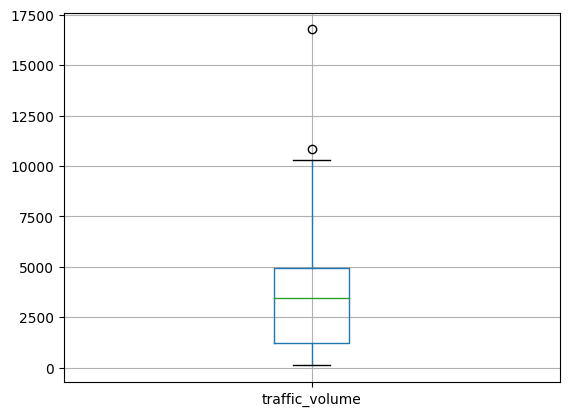

In [284]:
df.boxplot(column='traffic_volume')

<Axes: >

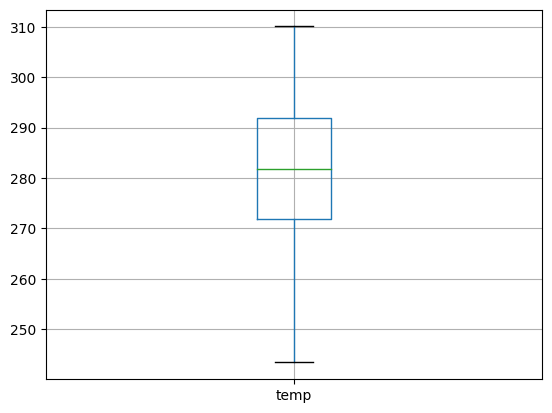

In [285]:
df.boxplot(column='temp')

<Axes: >

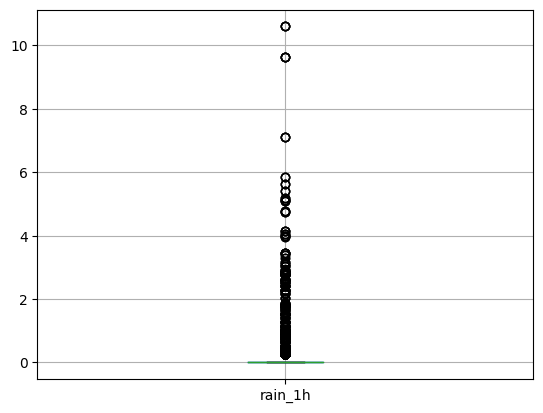

In [286]:
df.boxplot(column='rain_1h')

<Axes: >

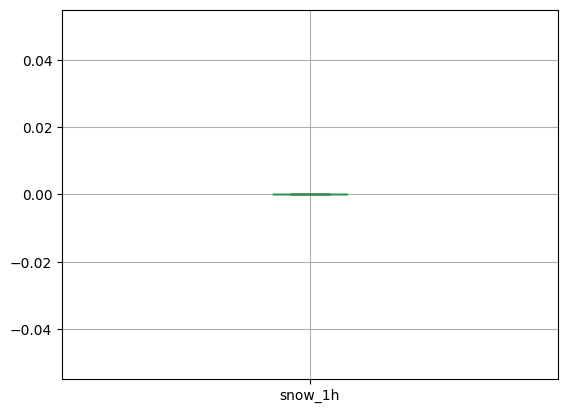

In [287]:
df.boxplot(column='snow_1h')

<Axes: >

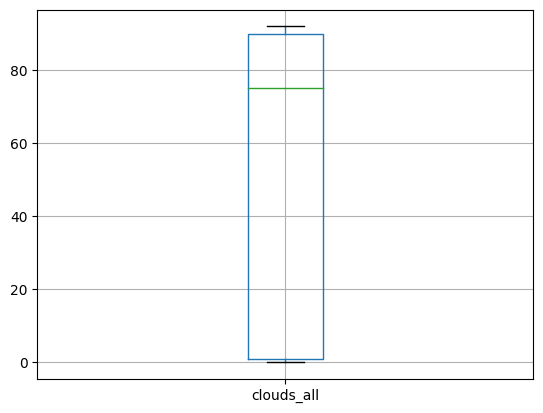

In [288]:
df.boxplot(column='clouds_all')


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [289]:
# I used fill forward before visualization
# df = df.ffill()

In [290]:
# Dropped snow_1h because all its values are zeros
df.drop(columns=['snow_1h', 'weather_main', 'weather_description'], inplace=True)

In [291]:
df.sort_index(inplace=True)

In [292]:
df.head()

,traffic_volume,temp,rain_1h,clouds_all
date_time,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,90
2016-11-18 15:00:00,4872.0,274.08,0.0,90
2016-11-18 15:00:00,4872.0,274.08,0.0,90
2016-11-18 16:00:00,5074.0,273.84,0.0,90
2016-11-18 16:00:00,5074.0,273.84,0.0,90


In [293]:
df = df[~df.index.duplicated(keep='first')].copy()

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16269 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  16269 non-null  float64
 1   temp            16269 non-null  float64
 2   rain_1h         16269 non-null  float64
 3   clouds_all      16269 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 635.5 KB


In [295]:
#df.resample('H')

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [296]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)
df['traffic_volume_diff'] = df['traffic_volume'].diff()

In [ ]:
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['day_of_year'] = df.index.dayofyear

In [297]:
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
clouds_all,0
prev_traffic_volume,1
traffic_volume_diff,1


In [298]:
df['prev_traffic_volume'].fillna(df['prev_traffic_volume'].mean(), inplace=True)
df['traffic_volume_diff'].fillna(df['traffic_volume_diff'].mean(), inplace=True)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [300]:
train = df.iloc[:int(0.8*len(df))]
val = df.iloc[int(0.8*len(df)):int(0.9*len(df))]
test = df.iloc[int(0.9*len(df)):]

In [301]:
train.index

DatetimeIndex(['2016-11-18 15:00:00', '2016-11-18 16:00:00',
               '2016-11-18 17:00:00', '2016-11-18 18:00:00',
               '2016-11-18 19:00:00', '2016-11-18 20:00:00',
               '2016-11-18 21:00:00', '2016-11-18 22:00:00',
               '2016-11-18 23:00:00', '2016-11-19 00:00:00',
               ...
               '2018-05-17 19:00:00', '2018-05-17 20:00:00',
               '2018-05-17 21:00:00', '2018-05-17 22:00:00',
               '2018-05-17 23:00:00', '2018-05-18 00:00:00',
               '2018-05-18 01:00:00', '2018-05-18 02:00:00',
               '2018-05-18 03:00:00', '2018-05-18 04:00:00'],
              dtype='datetime64[ns]', name='date_time', length=13015, freq=None)

In [302]:
val.index

DatetimeIndex(['2018-05-18 05:00:00', '2018-05-18 06:00:00',
               '2018-05-18 07:00:00', '2018-05-18 08:00:00',
               '2018-05-18 09:00:00', '2018-05-18 10:00:00',
               '2018-05-18 11:00:00', '2018-05-18 12:00:00',
               '2018-05-18 13:00:00', '2018-05-18 14:00:00',
               ...
               '2018-07-24 15:00:00', '2018-07-24 16:00:00',
               '2018-07-24 17:00:00', '2018-07-24 18:00:00',
               '2018-07-24 19:00:00', '2018-07-24 20:00:00',
               '2018-07-24 21:00:00', '2018-07-24 22:00:00',
               '2018-07-24 23:00:00', '2018-07-25 00:00:00'],
              dtype='datetime64[ns]', name='date_time', length=1627, freq=None)

In [303]:
test.index

DatetimeIndex(['2018-07-25 01:00:00', '2018-07-25 02:00:00',
               '2018-07-25 03:00:00', '2018-07-25 04:00:00',
               '2018-07-25 05:00:00', '2018-07-25 06:00:00',
               '2018-07-25 07:00:00', '2018-07-25 08:00:00',
               '2018-07-25 09:00:00', '2018-07-25 10:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=1627, freq=None)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [304]:
scaler = MinMaxScaler()

train = scaler.fit_transform(np.array(train).reshape(-1,1))
val = scaler.transform(np.array(val).reshape(-1,1))
test = scaler.transform(np.array(test).reshape(-1,1))

In [305]:
# daily patterns
window_size = 24
train_Xy = timeseries_dataset_from_array(train, targets=train[window_size:,0], sequence_length=window_size)
val_Xy = timeseries_dataset_from_array(val, targets=val[window_size:,0], sequence_length=window_size)
test_Xy = timeseries_dataset_from_array(test, targets=test[window_size:,0], sequence_length=window_size)


## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [306]:
model_rnn = Sequential()

model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_rnn.add(SimpleRNN(units=50, return_sequences=False))
model_rnn.add(Dense(units=1))

model_rnn.summary()

model_rnn.compile(loss='mean_squared_error',optimizer='adam', metrics=['mse'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)            │ (None, 24, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_12 (SimpleRNN)            │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [307]:
history_rnn = model_rnn.fit(train_Xy, validation_data=val_Xy, epochs=10, batch_size=32)

Epoch 1/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 3.5144e-04 - val_mse: 3.5144e-04
Epoch 2/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 3.9967e-04 - mse: 3.9967e-04 - val_loss: 2.2896e-04 - val_mse: 2.2896e-04
Epoch 3/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 2.8680e-04 - mse: 2.8680e-04 - val_loss: 1.6317e-04 - val_mse: 1.6317e-04
Epoch 4/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 2.2452e-04 - mse: 2.2452e-04 - val_loss: 2.7313e-04 - val_mse: 2.7313e-04
Epoch 5/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - loss: 2.2210e-04 - mse: 2.2210e-04 - val_loss: 1.4213e-04 - val_mse: 1.4213e-04
Epoch 6/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 2.1451e-04 - mse: 2.1451e-04 - val_loss: 1.4909e-04 - val_mse: 1.4909e-04
Epoch 7/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - loss: 1.9662e-04 - mse: 1.9662e-04 - val_loss: 1.5578e-04 - val_mse: 1.5578e-04
Epoch 8/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - 

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [309]:
X_test, y_test = next(iter(test_Xy))
y_pred = model_rnn.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [310]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred))
print('mean_squared_error: ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred))
print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_test, y_pred))

mean_absolute_error:  0.01587727148005567
mean_squared_error:  0.0003585253413083806
mean_absolute_error:  0.01587727148005567
mean_absolute_percentage_error:  0.037227322392404213


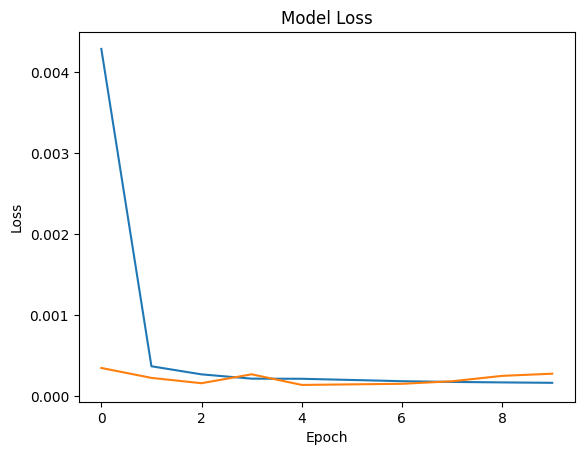

In [313]:
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

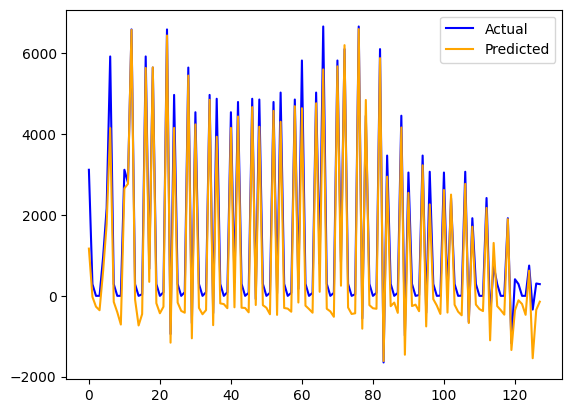

In [314]:
# Inverse scaling
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [317]:
from keras.layers import GRU
model_gru = Sequential([
    GRU(15, activation='tanh', return_sequences =True, input_shape=(X_train.shape[1], 1)),
    GRU(50, activation='tanh', return_sequences=True),
    GRU(50, activation='tanh', return_sequences =False),
    Dense(8, activation='relu'),
    Dense(1, activation='relu'),
])
model_gru.summary()
model_gru.compile(loss='mean_squared_error',optimizer='adam', metrics=['mse'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 24, 15)              │             810 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 24, 50)              │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,577 (103.82 KB)

 Trainable params: 26,577 (103.82 KB)

 Non-trainable params: 0 (0.00 B)

In [326]:
history_gru = model_gru.fit(train_Xy, validation_data=val_Xy, epochs=10, batch_size=32)

Epoch 1/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 57s 93ms/step - loss: 1.2588e-04 - mse: 1.2588e-04 - val_loss: 4.2837e-04 - val_mse: 4.2837e-04
Epoch 2/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step - loss: 1.5144e-04 - mse: 1.5144e-04 - val_loss: 1.0148e-04 - val_mse: 1.0148e-04
Epoch 3/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - loss: 1.0979e-04 - mse: 1.0979e-04 - val_loss: 8.2144e-05 - val_mse: 8.2144e-05
Epoch 4/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step - loss: 1.0522e-04 - mse: 1.0522e-04 - val_loss: 7.5376e-05 - val_mse: 7.5376e-05
Epoch 5/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - loss: 9.9137e-05 - mse: 9.9137e-05 - val_loss: 7.7869e-05 - val_mse: 7.7869e-05
Epoch 6/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step - loss: 9.3686e-05 - mse: 9.3686e-05 - val_loss: 6.6814e-05 - val_mse: 6.6814e-05
Epoch 7/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 56s 91ms/step - loss: 8.8137e-05 - mse: 8.8137e-05 - val_loss: 6.7875e-05 - val_mse: 6.7875e-05
Epoch 8/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 56s 92ms

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [327]:
X_test, y_test = next(iter(test_Xy))
y_pred = model_rnn.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [328]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred))
print('mean_squared_error: ', mean_squared_error(y_test, y_pred))
print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_test, y_pred))

mean_absolute_error:  0.01587727148005567
mean_squared_error:  0.0003585253413083806
mean_absolute_percentage_error:  0.037227322392404213


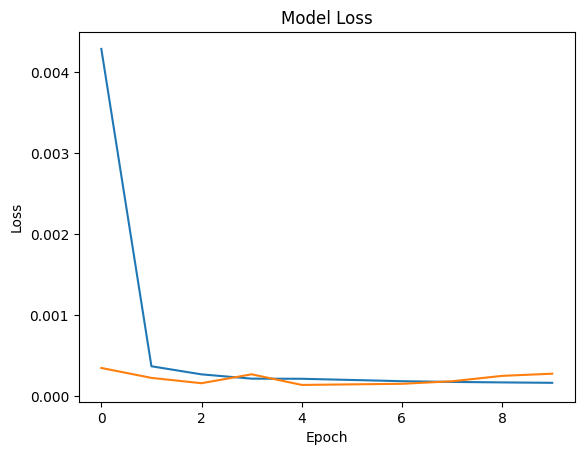

In [329]:
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

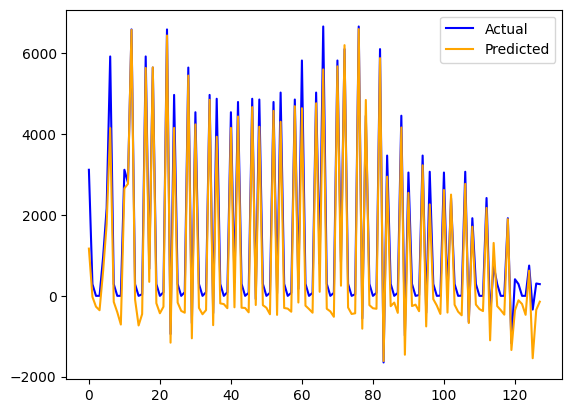

In [330]:
# Inverse scaling
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

- With time series, everything changed. First, loading the dataset I specified the index to be datetime. Data did not have many missing values only 20 null in traffic volume. I tackled that by using .ffil() function (fill forward). It takes the previous value and fill thu null value with it works better than taking the mean or mode in time series data. Normalizing the data, I used MinMax Scaler to handle my values and put them in a smaller range.

- For feature Engineering, I extract weekly and daily dates to help the model capture their seasonalities. Moreover, I created two features that give the model previous traffic volume and traffic difference.

- Archeticture of the models: I first implemented RNN as a simple neural network approach for sequence data. I only used two layers the first one return sequence, but the second one does not. It performed pretty well for its simplicity.
The second model is GRU which I created three layers with tanh activation functions to better capture long sequences.

- I chose 10 epochs as simple approach and to not let it have a long training time and with it the model was able to learn with only 10 epochs and 32 batch size. I experimented different values but I realized that the simpler the model the better it will perform

- I used MSE (Mean Squared Error) as a loss to models because of its robust to outliers and helpful in capturing how the model learns and I used another regression metric to evaluate the model's outcome MAE and MAPE

- No model tuning have been done

- My model's could slightly be overfitted and to mitigate that dropout layer could be used and batch normalization

- For future improvments, More data can be collected to capture traffic and five the model more indicators to figure out traffic volume. Moreover, we can add geospatial data so the model can learn and predict geospatial traffic and be more general through it.